In [170]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [192]:
h = 0.01
k = 0.01
x = torch.arange(0, 1, h)
y = torch.arange(0, 1, k)
X, Y = torch.meshgrid(x, y)
X = X.flatten()
Y = Y.flatten()

if torch.cuda.is_available():
    device = torch.device("cuda")
    X = X.to(device)
    Y = Y.to(device)

    print(device)

cuda


In [193]:
def initial_condition(x, y):

    Cl = torch.full_like(x, 0)

    Cp = torch.full_like(x, 0)

    for i, (xx, yy) in enumerate(zip(x, y)):
        if ((xx >= 0.5) and (xx <= 0.6)) and ((yy >= 0.5) and (yy <= 0.6)):
            Cp[i] = 0.2

    return torch.cat([Cl, Cp], dim=1)

In [194]:
C_initial = initial_condition(X.reshape(-1,1),Y.reshape(-1,1))

In [195]:
model = nn.Sequential(
    nn.Linear(3, 32),
    nn.Tanh(),
    nn.Linear(32, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 32),
    nn.Tanh(),
    nn.Linear(32, 32),
    nn.Tanh(),
    nn.Linear(32, 2),
).to(device)

print(model)

Sequential(
  (0): Linear(in_features=3, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): Tanh()
  (4): Linear(in_features=64, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): Tanh()
  (8): Linear(in_features=32, out_features=32, bias=True)
  (9): Tanh()
  (10): Linear(in_features=32, out_features=2, bias=True)
)


In [196]:
loss_fn = nn.MSELoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [197]:
len(X)

10000

In [202]:
n_epochs = 10000
batch_size = 100
C_loss_it = torch.zeros(n_epochs).to(device)


for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):

        t_initial = torch.zeros_like(X[i:i+batch_size].reshape(-1,1))

        input = torch.cat([X[i:i+batch_size].reshape(-1,1), Y[i:i+batch_size].reshape(-1,1),t_initial.reshape(-1,1)], dim=1)

        C_pred = model(input)

        Cbatch = C_initial[i:i+batch_size]
        
        loss = loss_fn(C_pred, Cbatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    C_loss_it[epoch] = loss.item()

    if epoch % 1000 == 0:
        print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 3.7268407595547615e-06
Finished epoch 1000, latest loss 1.8665920151761384e-06
Finished epoch 2000, latest loss 1.3157948330899671e-07
Finished epoch 3000, latest loss 8.953321639637579e-07
Finished epoch 4000, latest loss 3.2763600188445707e-07
Finished epoch 5000, latest loss 5.974161467747763e-07
Finished epoch 6000, latest loss 2.7484026077218005e-07
Finished epoch 7000, latest loss 1.0103821068696561e-06
Finished epoch 8000, latest loss 6.651635686694135e-08
Finished epoch 9000, latest loss 5.053501506147029e-10


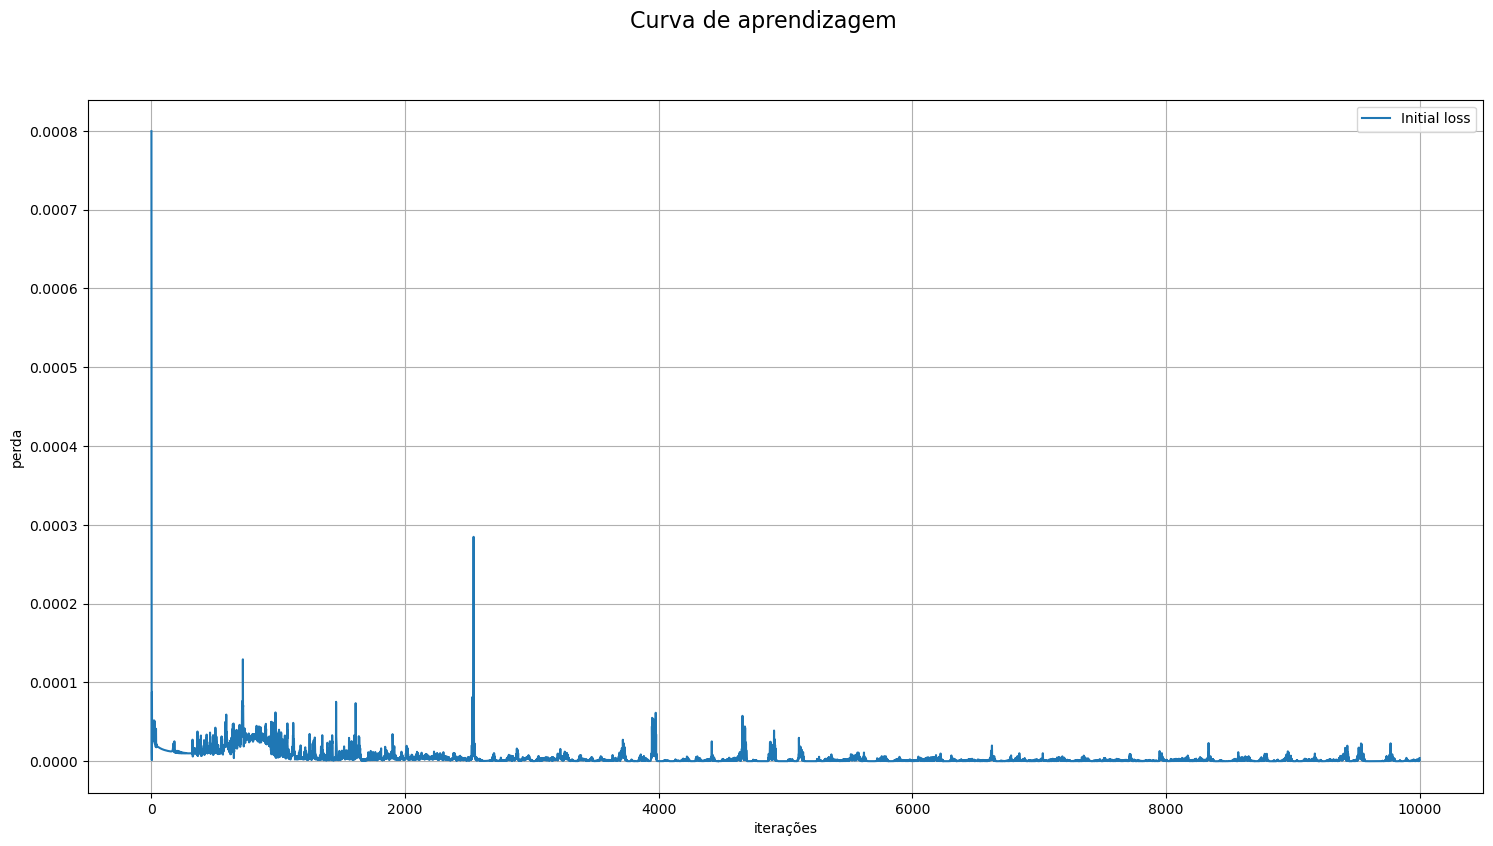

In [199]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[18, 9])

fig.suptitle('Curva de aprendizagem', fontsize=16)


# Plotango 3D
ax = fig.add_subplot(1, 1, 1)

ax.set_xlabel("iterações")
ax.set_ylabel("perda")
ax.plot(range(len(C_loss_it.cpu().numpy())),C_loss_it.cpu().numpy(),label="Initial loss")
# ax.set_yscale("log")
ax.grid()
ax.legend()

plt.show()

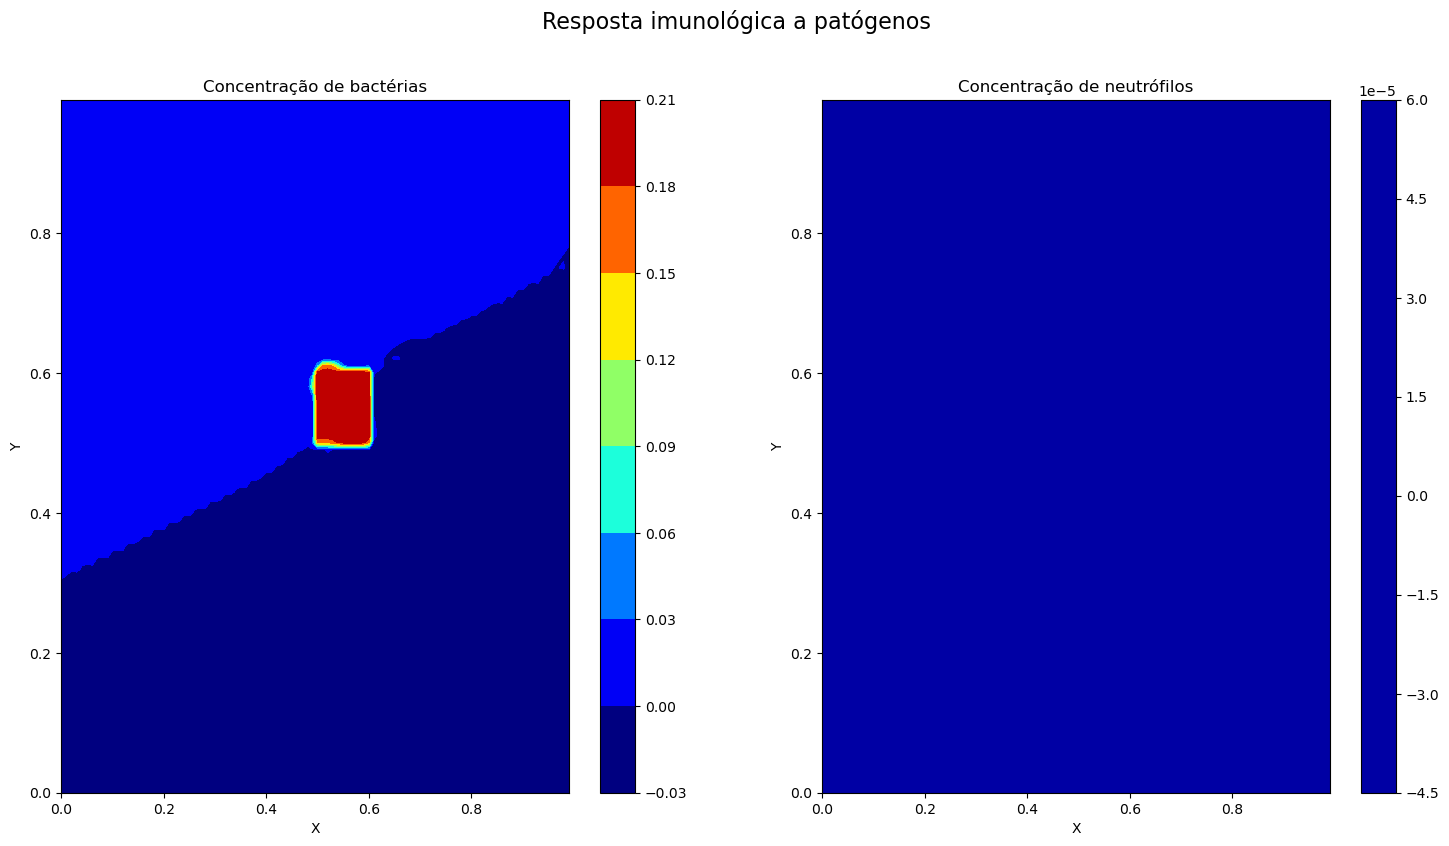

In [200]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

fig = plt.figure(figsize=[18, 9])

fig.suptitle("Resposta imunológica a patógenos", fontsize=16)

t_initial = torch.zeros_like(X)

with torch.no_grad():
    input_data = torch.stack([X.flatten(), Y.flatten(), t_initial.flatten()], dim=1)

    solution = model(input_data)


Cl, Cp = solution.split(1, dim=1)

Cl_plot = Cl.reshape(len(x), -1).cpu().numpy()
Cp_plot = Cp.reshape(len(x), -1).cpu().numpy()

X_cpu = X.reshape(len(x), -1).cpu().numpy()
Y_cpu = Y.reshape(len(x), -1).cpu().numpy()

vmin = np.min([np.min(Cp_plot), np.min(Cl_plot)])
vmax = np.max([np.max(Cp_plot), np.max(Cl_plot)])

# Plotango 3D
ax = fig.add_subplot(1, 2, 1)

contour = ax.contourf(X_cpu, Y_cpu, Cp_plot, cmap="jet", vmin=vmin, vmax=vmax)
ax.set_title("Concentração de bactérias")
ax.set_xlabel("X")
ax.set_ylabel("Y")
colobar = fig.colorbar(contour)

# Plotando 2D

ax = fig.add_subplot(1, 2, 2)

contour = ax.contourf(X_cpu, Y_cpu, Cl_plot, cmap="jet", vmin=vmin, vmax=vmax)
ax.set_title("Concentração de neutrófilos")
ax.set_xlabel("X")
ax.set_ylabel("Y")

colobar = fig.colorbar(contour)

plt.show()